In [8]:
!unzip data.zip

Archive:  data.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


In [21]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 데이터 디렉토리 정의
data_dir = "./"

In [ ]:
# --- 1. EDA (탐색적 데이터 분석) ---
print("--- EDA 시작 (대표 파일: AEP_hourly.csv) ---")
aep_df = pd.read_csv(os.path.join(data_dir, 'AEP_hourly.csv'), parse_dates=['Datetime'])
aep_df = aep_df.set_index('Datetime').sort_index()

# EDA 1: 전체 시계열 플롯
plt.figure(figsize=(15, 5))
aep_df['AEP_MW'].plot()
plt.title('전체 AEP 에너지 소비 (MW)')
plt.ylabel('AEP_MW')
plt.grid(True)
plt.savefig('eda_full_timeseries.png')
plt.show()

# EDA 2: 2018년 1월 데이터 (계절성/패턴 확인)
plt.figure(figsize=(15, 5))
aep_df['AEP_MW'].loc['2018-01-01':'2018-01-31'].plot()
plt.title('2018년 1월 AEP 에너지 소비 (MW)')
plt.ylabel('AEP_MW')
plt.grid(True)
plt.savefig('eda_jan_2018.png')
plt.show()

In [23]:
# --- 2. 데이터 전처리 (원본 코드 기반) ---
# 원본 코드의 전처리 로직은 그대로 사용합니다.
label_scalers = {}
train_x_list = []
train_y_list = []
test_x_dict = {}
test_y_dict = {}

print("데이터 전처리 시작...")
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv") and f != "pjm_hourly_est.csv"]

데이터 전처리 시작...


In [24]:
for file in tqdm_notebook(csv_files): 
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=[0])
    
    # 시간 특징 추가
    df['hour'] = df['Datetime'].dt.hour
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['month'] = df['Datetime'].dt.month
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df = df.sort_values("Datetime").drop("Datetime", axis=1)
    
    # 스케일링
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # 시퀀스 데이터 생성 (Lookback=90)
    lookback = 90
    inputs = np.zeros((len(data) - lookback, lookback, df.shape[1]))
    labels = np.zeros(len(data) - lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    
    inputs = inputs.reshape(-1, lookback, df.shape[1])
    labels = labels.reshape(-1, 1)
    
    # 훈련/테스트 분할 (파일별 마지막 10%를 테스트용으로)
    test_portion = int(0.1 * len(inputs))
    train_x_list.append(inputs[:-test_portion])
    train_y_list.append(labels[:-test_portion])
    test_x_dict[file] = inputs[-test_portion:]
    test_y_dict[file] = labels[-test_portion:]

# 모든 훈련 데이터를 하나로 결합
train_x_combined = np.concatenate(train_x_list)
train_y_combined = np.concatenate(train_y_list)

print(f"\n총 훈련 시퀀스 (결합됨): {train_x_combined.shape}")

  0%|          | 0/12 [00:00<?, ?it/s]


총 훈련 시퀀스 (결합됨): (980185, 90, 5)


In [25]:
# --- 3. 훈련/검증 데이터로더 생성 (수정된 부분) ---
batch_size = 1024

# 결합된 훈련 데이터를 다시 훈련셋과 검증셋으로 분리 (8:2)
X_train, X_val, y_train, y_val = train_test_split(
    train_x_combined, train_y_combined, test_size=0.2, random_state=42
)

# PyTorch Tensor로 변환
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

# DataLoader 생성
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=False) # 검증셋은 셔플 불필요

print(f"최종 훈련 데이터로더 배치 수: {len(train_loader)}")
print(f"최종 검증 데이터로더 배치 수: {len(val_loader)}")


# GPU 설정
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(f"\n사용 디바이스: {device}")

최종 훈련 데이터로더 배치 수: 765
최종 검증 데이터로더 배치 수: 192

사용 디바이스: cuda


In [26]:
# --- 4. 모델 정의 (원본 코드 유지) ---
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [27]:
# --- 5. 훈련 함수 (수정된 부분: 검증 로직 추가) ---
def train_model(train_loader, val_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    loss_history = {'train_loss': [], 'val_loss': []}
    
    print(f"\n--- {model_type} 모델 훈련 시작 ---")
    for epoch in range(1, EPOCHS + 1):
        model.train() # 훈련 모드
        train_loss = 0.0
        h = model.init_hidden(batch_size)
        
        for x, label in train_loader:
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
                
            model.zero_grad()
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Epoch 종료 후 검증
        model.eval() # 평가 모드
        val_loss = 0.0
        val_h = model.init_hidden(batch_size) # 검증 로더 배치 크기에 맞게 초기화 (마지막 배치가 작을 수 있음)
        
        with torch.no_grad():
            for x_val, label_val in val_loader:
                # 마지막 배치가 batch_size와 다를 경우 hidden state 크기 재조정
                if x_val.shape[0] != val_h[0].shape[1] if model_type == "LSTM" else x_val.shape[0] != val_h.shape[1]:
                    val_h = model.init_hidden(x_val.shape[0])

                out_val, val_h = model(x_val.to(device).float(), val_h)
                v_loss = criterion(out_val, label_val.to(device).float())
                val_loss += v_loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        loss_history['train_loss'].append(avg_train_loss)
        loss_history['val_loss'].append(avg_val_loss)
        
        print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    return model, loss_history


In [28]:
# 평가 함수 (원본 코드 유지 - time.clock은 perf_counter로 변경)
def evaluate(model, test_x, test_y, label_scalers, model_type="GRU"):
    model.eval()
    outputs = []
    targets = []
    start_time = time.perf_counter() # time.clock() 대신 perf_counter() 사용
    
    for file_key in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[file_key]))
        labs = torch.from_numpy(np.array(test_y[file_key]))
        
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        
        # 스케일 역변환
        outputs.append(label_scalers[file_key].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[file_key].inverse_transform(labs.numpy()).reshape(-1))
        
    print(f"Evaluation Time: {time.perf_counter() - start_time:.4f} 초")
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(np.abs(outputs[i] - targets[i]) / (np.abs(targets[i]) + np.abs(outputs[i])) / 2) / len(outputs)
        
    print(f"{model_type} sMAPE: {sMAPE*100:.4f}%")
    return outputs, targets, sMAPE

In [29]:
# --- 6. 모델 훈련 실행 (GRU 및 LSTM) ---
lr = 0.001
EPOCHS = 5

# GRU 모델 훈련
gru_model, gru_history = train_model(train_loader, val_loader, lr, model_type="GRU", EPOCHS=EPOCHS)

# LSTM 모델 훈련
lstm_model, lstm_history = train_model(train_loader, val_loader, lr, model_type="LSTM", EPOCHS=EPOCHS)

# --- 7. 결과 분석 및 시각화 (개선된 부분) ---

print("\n--- 최종 모델 평가 (Test Set) ---")
# GRU 평가
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x_dict, test_y_dict, label_scalers, model_type="GRU")
# LSTM 평가
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x_dict, test_y_dict, label_scalers, model_type="LSTM")


--- GRU 모델 훈련 시작 ---
Epoch 1/5 | Train Loss: 0.002109 | Val Loss: 0.000242
Epoch 2/5 | Train Loss: 0.000248 | Val Loss: 0.000167
Epoch 3/5 | Train Loss: 0.000192 | Val Loss: 0.000126
Epoch 4/5 | Train Loss: 0.000153 | Val Loss: 0.000115
Epoch 5/5 | Train Loss: 0.000134 | Val Loss: 0.000117

--- LSTM 모델 훈련 시작 ---
Epoch 1/5 | Train Loss: 0.002923 | Val Loss: 0.000270
Epoch 2/5 | Train Loss: 0.000242 | Val Loss: 0.000139
Epoch 3/5 | Train Loss: 0.000172 | Val Loss: 0.000185
Epoch 4/5 | Train Loss: 0.000148 | Val Loss: 0.000129
Epoch 5/5 | Train Loss: 0.000130 | Val Loss: 0.000088

--- 최종 모델 평가 (Test Set) ---
Evaluation Time: 0.7195 초
GRU sMAPE: 0.3141%
Evaluation Time: 0.9367 초
LSTM sMAPE: 0.2537%



결과 1: 훈련/검증 손실 비교 'training_loss_comparison.png' 저장 완료.


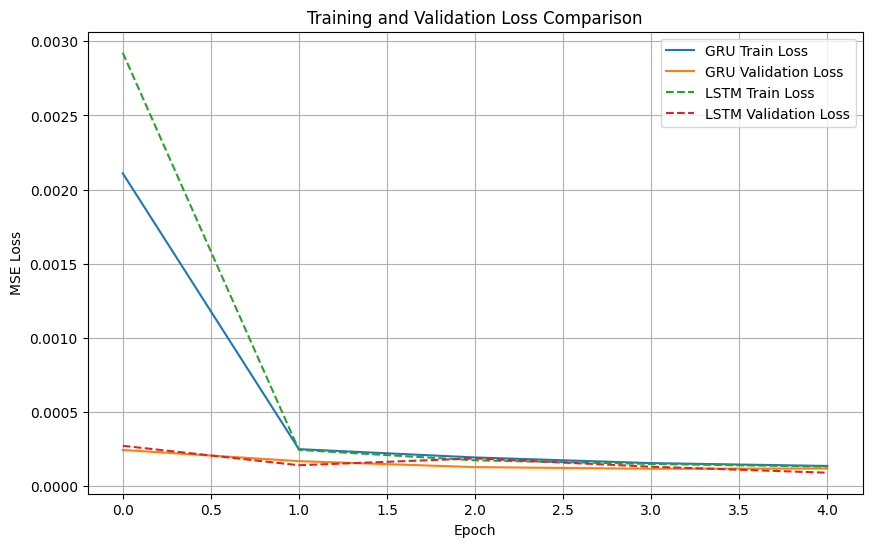

In [30]:
# 결과 1: 훈련/검증 손실 비교 플롯
plt.figure(figsize=(10, 6))
plt.plot(gru_history['train_loss'], label="GRU Train Loss")
plt.plot(gru_history['val_loss'], label="GRU Validation Loss")
plt.plot(lstm_history['train_loss'], label="LSTM Train Loss", linestyle='--')
plt.plot(lstm_history['val_loss'], label="LSTM Validation Loss", linestyle='--')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_comparison.png')
print("\n결과 1: 훈련/검증 손실 비교 'training_loss_comparison.png' 저장 완료.")
plt.show()

결과 2: 예측 비교 시각화 'prediction_comparison_plots.png' 저장 완료.


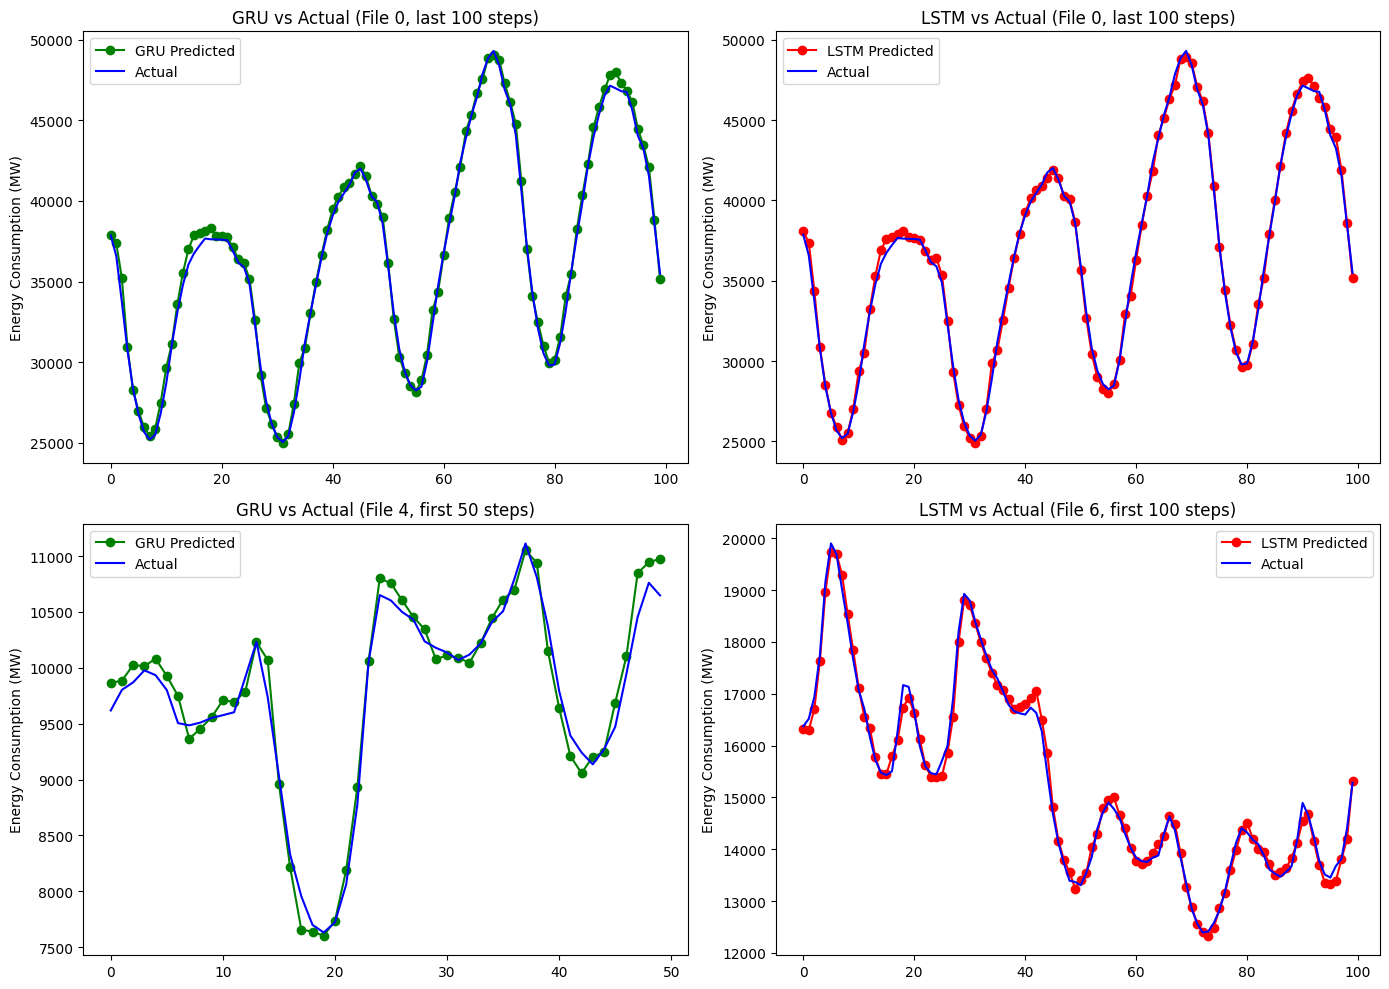

In [31]:
# 결과 2: 예측 시각화 비교 (원본 플롯 수정)
plt.figure(figsize=(14, 10))

# GRU 예측 (원본의 첫 번째 플롯)
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('GRU vs Actual (File 0, last 100 steps)')
plt.legend()

# LSTM 예측 (새로 추가)
plt.subplot(2, 2, 2)
plt.plot(lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('LSTM vs Actual (File 0, last 100 steps)')
plt.legend()

# GRU 예측 (원본의 세 번째 플롯)
plt.subplot(2, 2, 3)
plt.plot(gru_outputs[4][:50], "-o", color="g", label="GRU Predicted")
plt.plot(targets[4][:50], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('GRU vs Actual (File 4, first 50 steps)')
plt.legend()

# LSTM 예측 (원본의 네 번째 플롯 수정)
plt.subplot(2, 2, 4)
plt.plot(lstm_outputs[6][:100], "-o", color="r", label="LSTM Predicted")
plt.plot(targets[6][:100], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('LSTM vs Actual (File 6, first 100 steps)')
plt.legend()

plt.tight_layout()
plt.savefig('prediction_comparison_plots.png')
print("결과 2: 예측 비교 시각화 'prediction_comparison_plots.png' 저장 완료.")
plt.show()